# Importing Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import seaborn as sns


import sys
import warnings

import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

# Functions

In [2]:
def rmsle(y, pred):
    log_y    = np.log1p(y)
    log_pred = np.log1p(pred)
    rmsle = np.sqrt(np.mean((log_y-log_pred)**2.))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_error(y, pred, show=True):
    rmsle_val = rmsle(y, pred)
    rmse_val  = rmse(y, pred)
    mae_val   = mean_absolute_error(y, pred)
    if show:
        print('RMSLE: {0:.4f}'.format(rmsle_val), end=" | ")
        print('RMSE : {0:.4f}'.format(rmse_val), end=" | ")
        print('MAE  : {0:.4f}'.format(mae_val))
    return rmsle_val, rmse_val, mae_val

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            n_jobs=n_jobs, 
                                                            scoring='neg_mean_squared_error', 
                                                            train_sizes=train_sizes)
        
    train_scores = np.sqrt(-1*train_scores)
    test_scores  = np.sqrt(-1*test_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [4]:
def grid_search(estimator, params, X, y, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=1):

    grid_reg = GridSearchCV(estimator, param_grid=params, scoring=scoring, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_reg.fit(X, y)

    grid_best_socre = np.sqrt(-1*grid_reg.best_score_)
    print(grid_reg.best_params_, grid_best_socre)
    
    return grid_reg

In [5]:
def get_top_bottom_coef(model, X_features, n):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

In [6]:
def visualize_coefficient(model, X_features, n=10, figsize=(8,10)):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, ax = plt.subplots(figsize=figsize)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 

    # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
    coef_high, coef_low = get_top_bottom_coef(model, X_features, n)
    coef_concat = pd.concat( [coef_high , coef_low] )
    # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
    ax.set_title(model.__class__.__name__+' Coeffiecents', size=12)
    #ax.tick_params(axis="y",direction="in", pad=-120)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)
    sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=ax)

# Loading Train and Test Sets

In [7]:
train = pd.read_csv('./input/train.csv', index_col='id')
test  = pd.read_csv('./input/test.csv', index_col='id')

# Information on train and test

In [201]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 1 to 499999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cont0   300000 non-null  float64
 11  cont1   300000 non-null  float64
 12  cont2   300000 non-null  float64
 13  cont3   300000 non-null  float64
 14  cont4   300000 non-null  float64
 15  cont5   300000 non-null  float64
 16  cont6   300000 non-null  float64
 17  cont7   300000 non-null  float64
 18  cont8   300000 non-null  float64
 19  cont9   300000 non-null  float64
 20  cont10  300000 non-null  float64
 21  cont11  30

In [125]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 499995
Data columns (total 24 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    200000 non-null  object 
 1   cat1    200000 non-null  object 
 2   cat2    200000 non-null  object 
 3   cat3    200000 non-null  object 
 4   cat4    200000 non-null  object 
 5   cat5    200000 non-null  object 
 6   cat6    200000 non-null  object 
 7   cat7    200000 non-null  object 
 8   cat8    200000 non-null  object 
 9   cat9    200000 non-null  object 
 10  cont0   200000 non-null  float64
 11  cont1   200000 non-null  float64
 12  cont2   200000 non-null  float64
 13  cont3   200000 non-null  float64
 14  cont4   200000 non-null  float64
 15  cont5   200000 non-null  float64
 16  cont6   200000 non-null  float64
 17  cont7   200000 non-null  float64
 18  cont8   200000 non-null  float64
 19  cont9   200000 non-null  float64
 20  cont10  200000 non-null  float64
 21  cont11  20

<AxesSubplot:xlabel='target'>

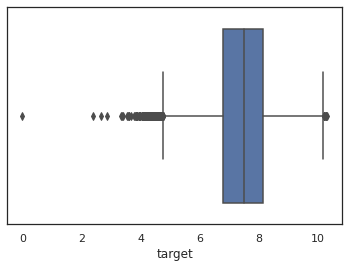

In [126]:
sns.boxplot(data=train, x='target')

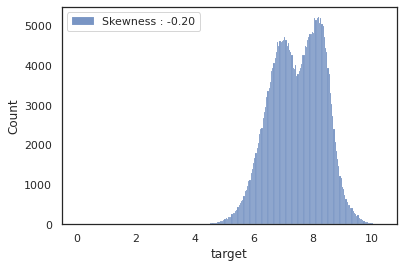

In [38]:
g= sns.histplot(data=train, x='target', label="Skewness : %.2f"%(train["target"].skew()))
g.legend()

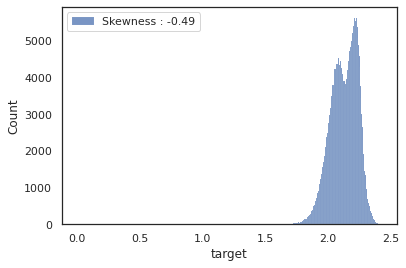

In [39]:
g = sns.histplot(np.log1p(train['target']), label="Skewness : %.2f"%(np.log1p(train["target"]).skew()))
g.legend()

# Outlier detection

In [8]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    #outlier_indices = Counter(outlier_indices)    
    #multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    #return multiple_outliers 
    
    return outlier_indices

In [9]:
target_outliers = detect_outliers(train, 1, ["target"])
print(len(target_outliers))

359


In [10]:
train_copy = train.copy()
train.drop(target_outliers, axis=0, inplace=True)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299641 entries, 1 to 499999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    299641 non-null  object 
 1   cat1    299641 non-null  object 
 2   cat2    299641 non-null  object 
 3   cat3    299641 non-null  object 
 4   cat4    299641 non-null  object 
 5   cat5    299641 non-null  object 
 6   cat6    299641 non-null  object 
 7   cat7    299641 non-null  object 
 8   cat8    299641 non-null  object 
 9   cat9    299641 non-null  object 
 10  cont0   299641 non-null  float64
 11  cont1   299641 non-null  float64
 12  cont2   299641 non-null  float64
 13  cont3   299641 non-null  float64
 14  cont4   299641 non-null  float64
 15  cont5   299641 non-null  float64
 16  cont6   299641 non-null  float64
 17  cont7   299641 non-null  float64
 18  cont8   299641 non-null  float64
 19  cont9   299641 non-null  float64
 20  cont10  299641 non-null  float64
 21  cont11  29

## 1. Categorical Features

In [143]:
for i in range(10):
    feature = 'cat' + str(i)
    print(train[feature].value_counts())

A    281141
B     18500
Name: cat0, dtype: int64
A    162445
B    137196
Name: cat1, dtype: int64
A    276213
B     23428
Name: cat2, dtype: int64
C    183607
A    104260
D     11165
B       609
Name: cat3, dtype: int64
B    297016
A      1240
C       767
D       618
Name: cat4, dtype: int64
B    149084
D    134961
C     11720
A      3876
Name: cat5, dtype: int64
A    292299
B      6337
C       801
D       147
I        24
E        19
H        11
G         3
Name: cat6, dtype: int64
E    267316
D     24321
B      5742
G      1961
F       278
A        14
C         6
I         3
Name: cat7, dtype: int64
C    120912
E     94544
G     42101
A     37829
D      3693
F       548
B        14
Name: cat8, dtype: int64
F    107088
I     50009
L     42180
H     24729
K     20942
A     13392
G     10403
M      9831
J      6971
O      6167
N      4111
B      3433
C       209
D       103
E        73
Name: cat9, dtype: int64


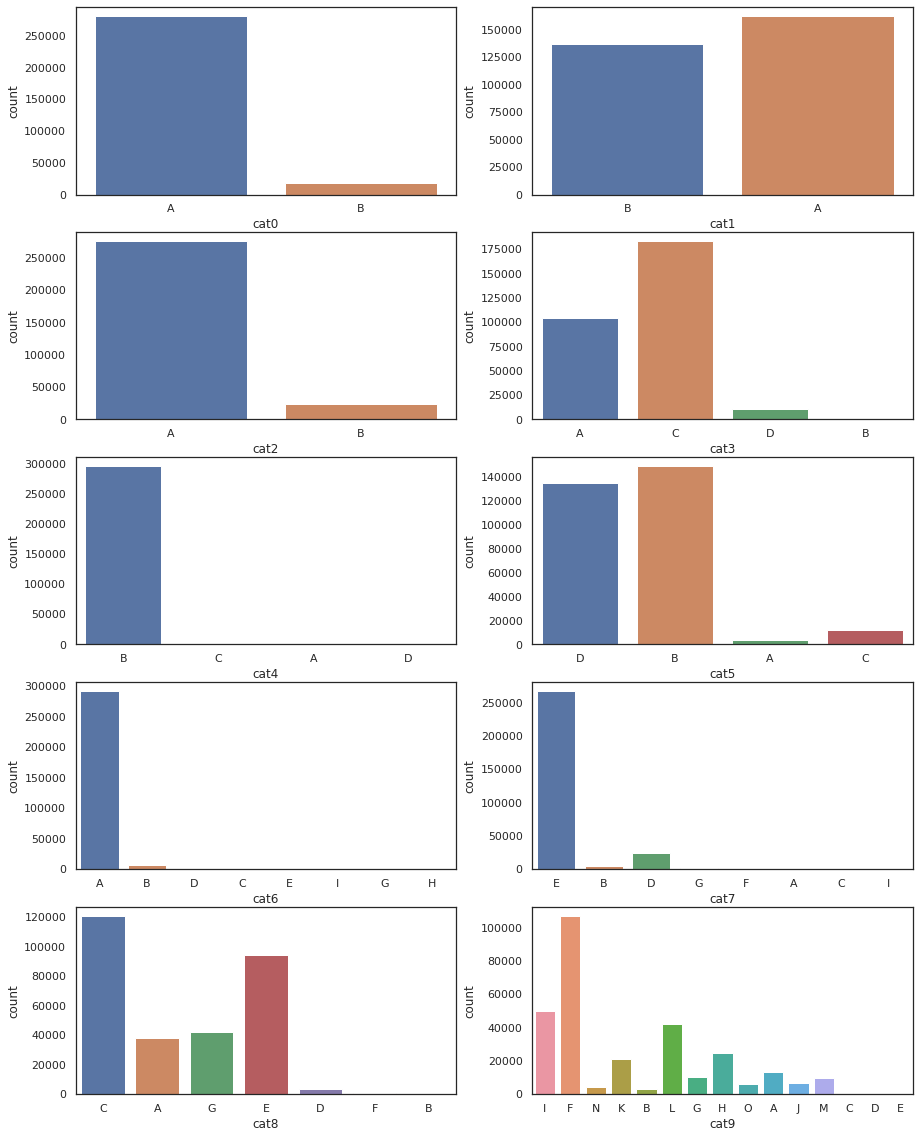

In [66]:
idx = np.arange(10, dtype=int).reshape(5,2)
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
for i in range(5):
    for j in range(2):
        feature = 'cat'+str(idx[i][j])
        sns.countplot(data=train, x=feature,ax=ax[i][j])
plt.show()

## 2. Numeric features

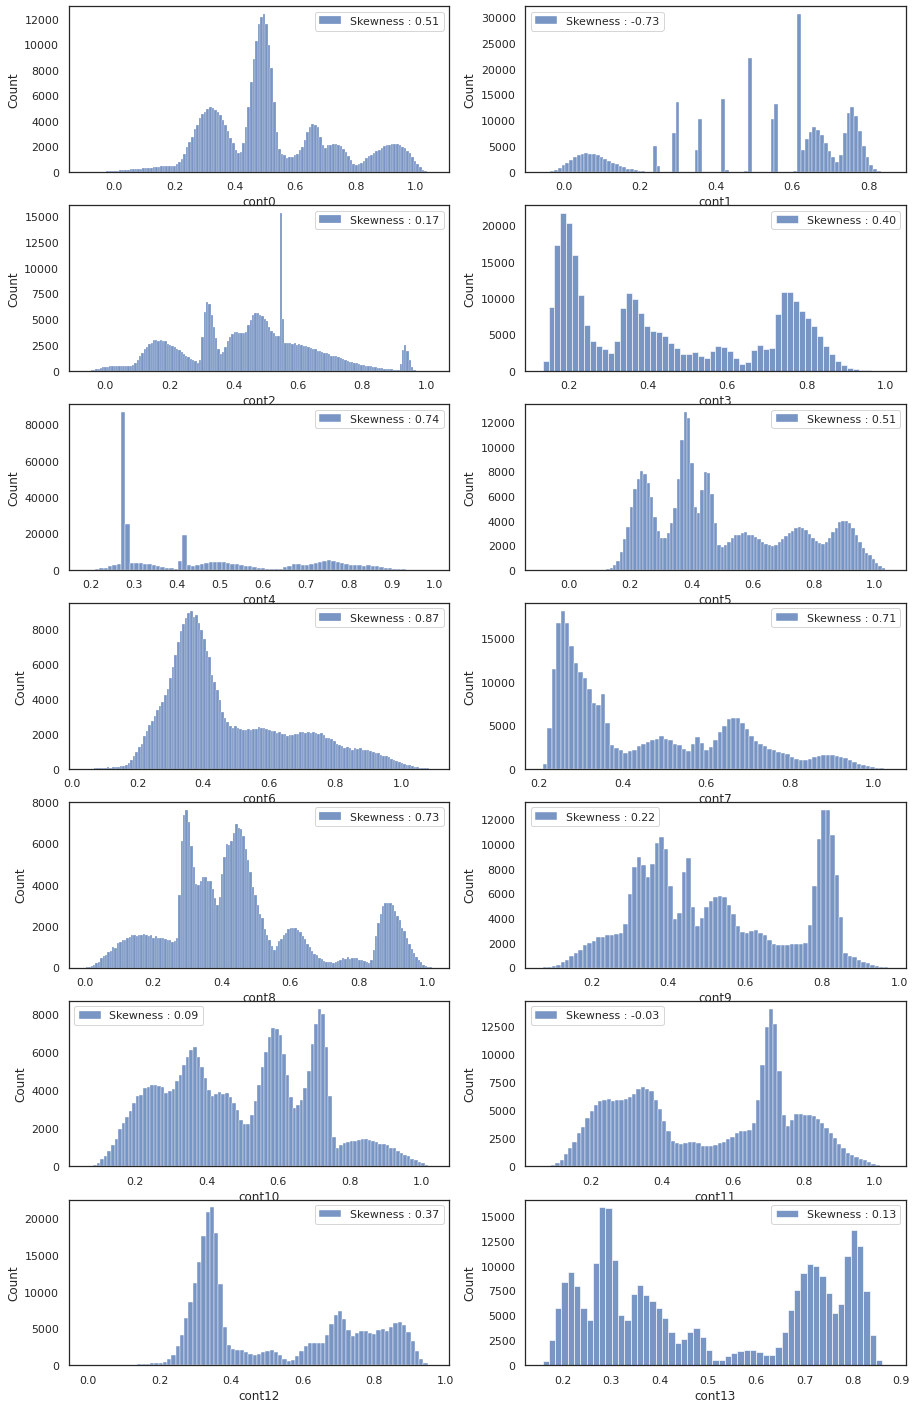

In [70]:
idx = np.arange(14, dtype=int).reshape(7,2)
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(15, 25))
for i in range(7):
    for j in range(2):
        feature = 'cont'+str(idx[i][j])
        sns.histplot(train[feature], ax=ax[i][j], label="Skewness : %.2f"%(train[feature].skew()))
        ax[i][j].legend()
plt.show()

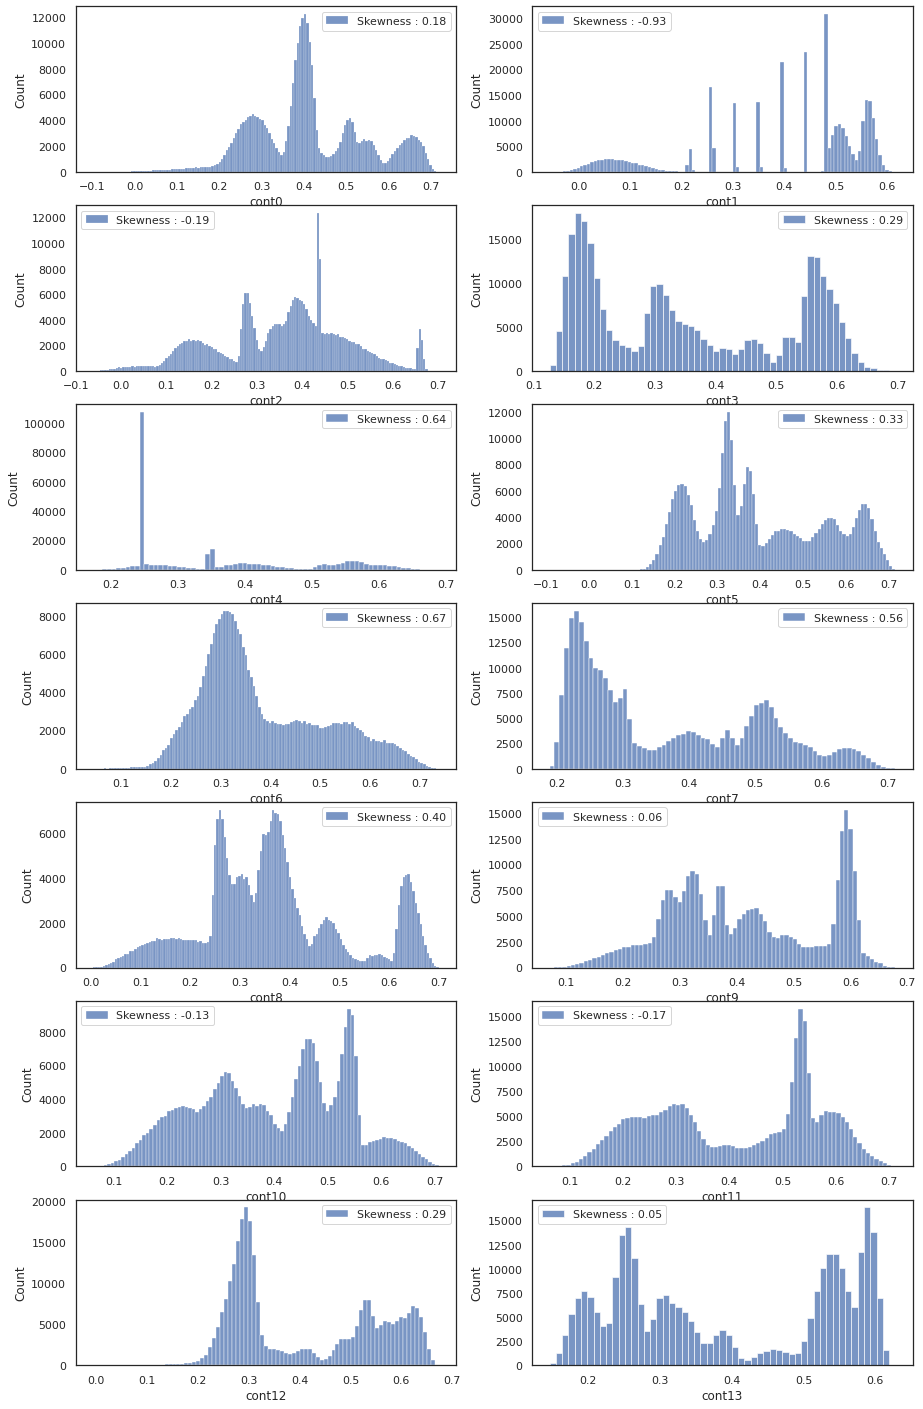

In [71]:
idx = np.arange(14, dtype=int).reshape(7,2)
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(15, 25))
for i in range(7):
    for j in range(2):
        feature = 'cont'+str(idx[i][j])
        data_plot = np.log1p(train[feature])
        sns.histplot(data_plot, ax=ax[i][j], label="Skewness : %.2f"%(data_plot.skew()))
        ax[i][j].legend()
plt.show()

In [64]:
idx = np.arange(14, dtype=int)
for i in range(14):
    feature = 'cont'+str(idx[i])
    skew_org = train[feature].skew()
    skew_log = np.log1p(train[feature]).skew()
    if abs(skew_org) > abs(skew_log):
        symbol = "log"
    else:
        symbol = "org"
    print("{0:10s} | {1:7.2f} : {2:7.2f} -> {3}".format(feature, skew_org, skew_log, symbol))

cont0      |    0.51 :    0.18 -> log
cont1      |   -0.73 :   -0.93 -> org
cont2      |    0.17 :   -0.19 -> org
cont3      |    0.40 :    0.29 -> log
cont4      |    0.74 :    0.64 -> log
cont5      |    0.51 :    0.33 -> log
cont6      |    0.87 :    0.67 -> log
cont7      |    0.71 :    0.56 -> log
cont8      |    0.73 :    0.40 -> log
cont9      |    0.22 :    0.06 -> log
cont10     |    0.09 :   -0.13 -> org
cont11     |   -0.03 :   -0.17 -> org
cont12     |    0.37 :    0.29 -> log
cont13     |    0.13 :    0.05 -> log


In [47]:
cont_features = ['cont'+str(i) for i in range(14)]
features = cont_features + ['target']
corr = train[features].corr()['target'].sort_values(ascending=False)
print(corr)

target    1.000000
cont1     0.037071
cont7     0.024184
cont11    0.021099
cont8     0.019530
cont6     0.015525
cont13    0.005116
cont12    0.004569
cont2     0.001815
cont9     0.001073
cont3    -0.005081
cont4    -0.016421
cont10   -0.019837
cont5    -0.023552
cont0    -0.037671
Name: target, dtype: float64


In [ ]:
cont_f = ['cont1', 'cont7', 'cont11', 'cont8', 'cont6', 'cont4', 'cont10', 'cont5', 'cont0']

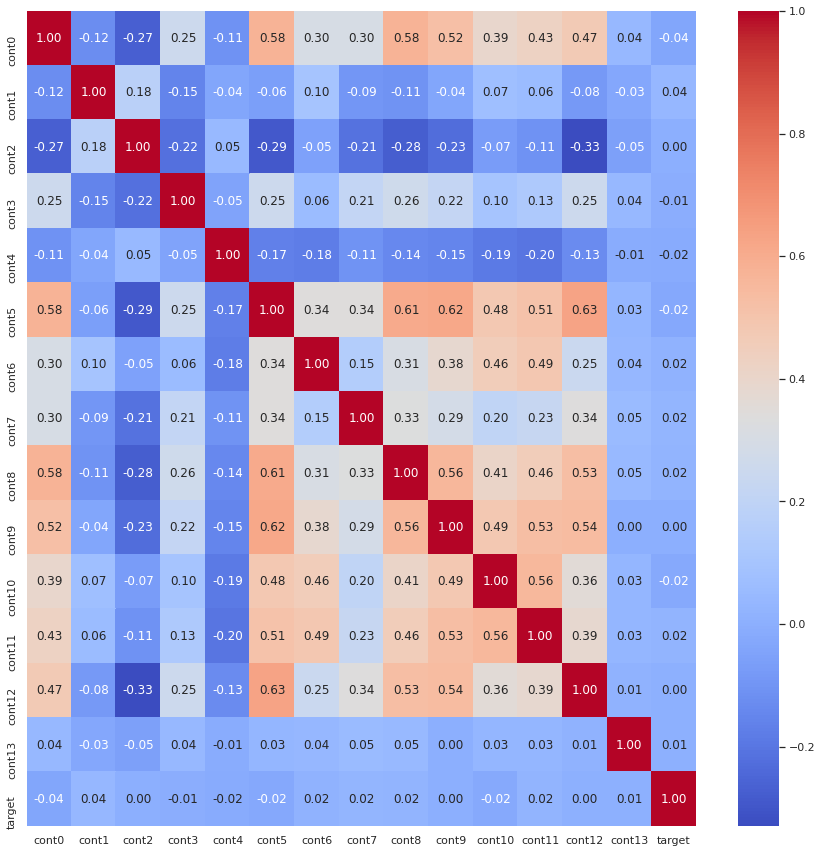

In [48]:
plt.figure(figsize=(15,15))
sns.heatmap(train[features].corr(), annot=True, fmt = ".2f", cmap = "coolwarm")
plt.show()

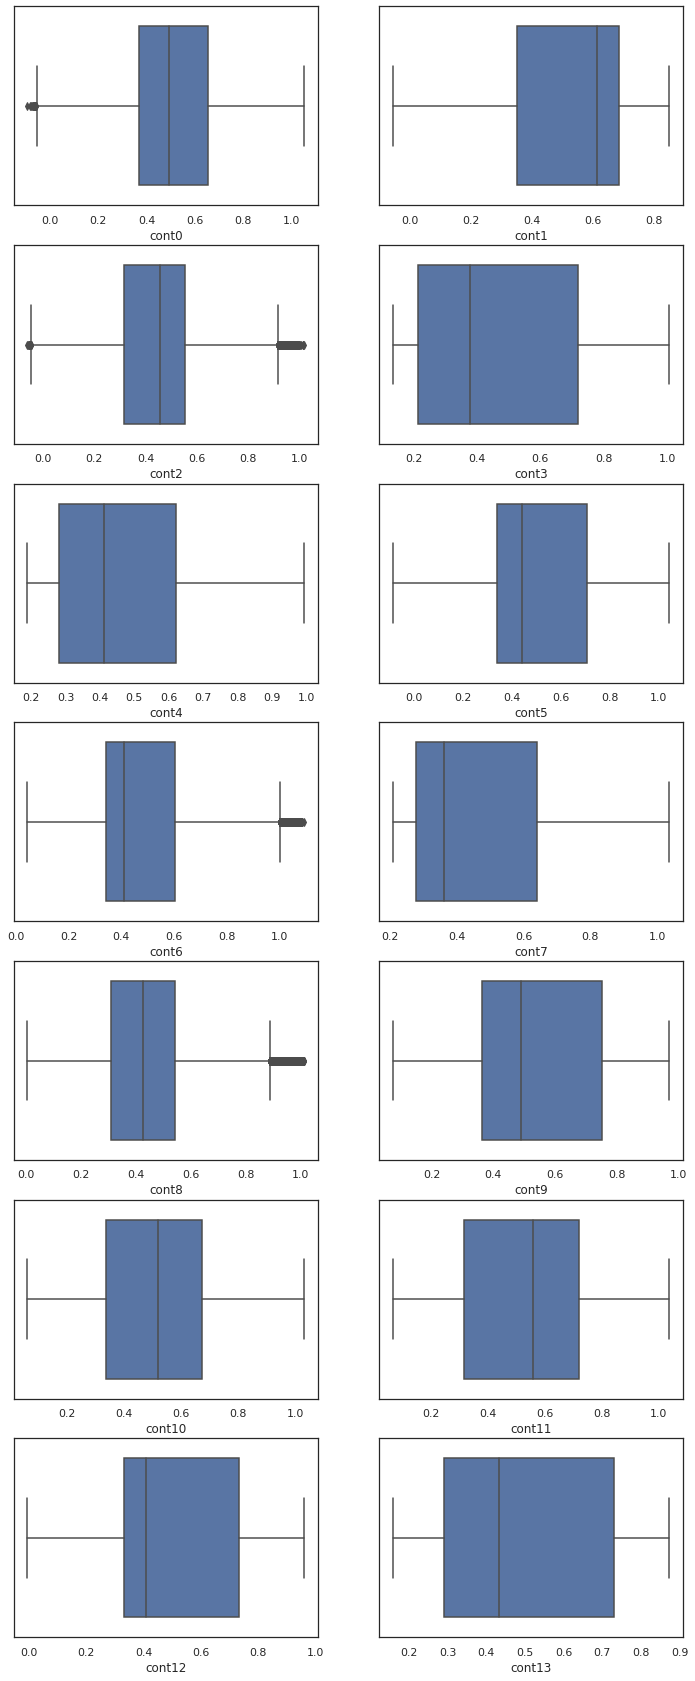

In [49]:
idx = np.arange(14, dtype=int).reshape(7,2)
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(12, 30))
for i in range(7):
    for j in range(2):
        sns.boxplot(data=train, x='cont'+str(idx[i][j]), ax=ax[i][j])
plt.show()

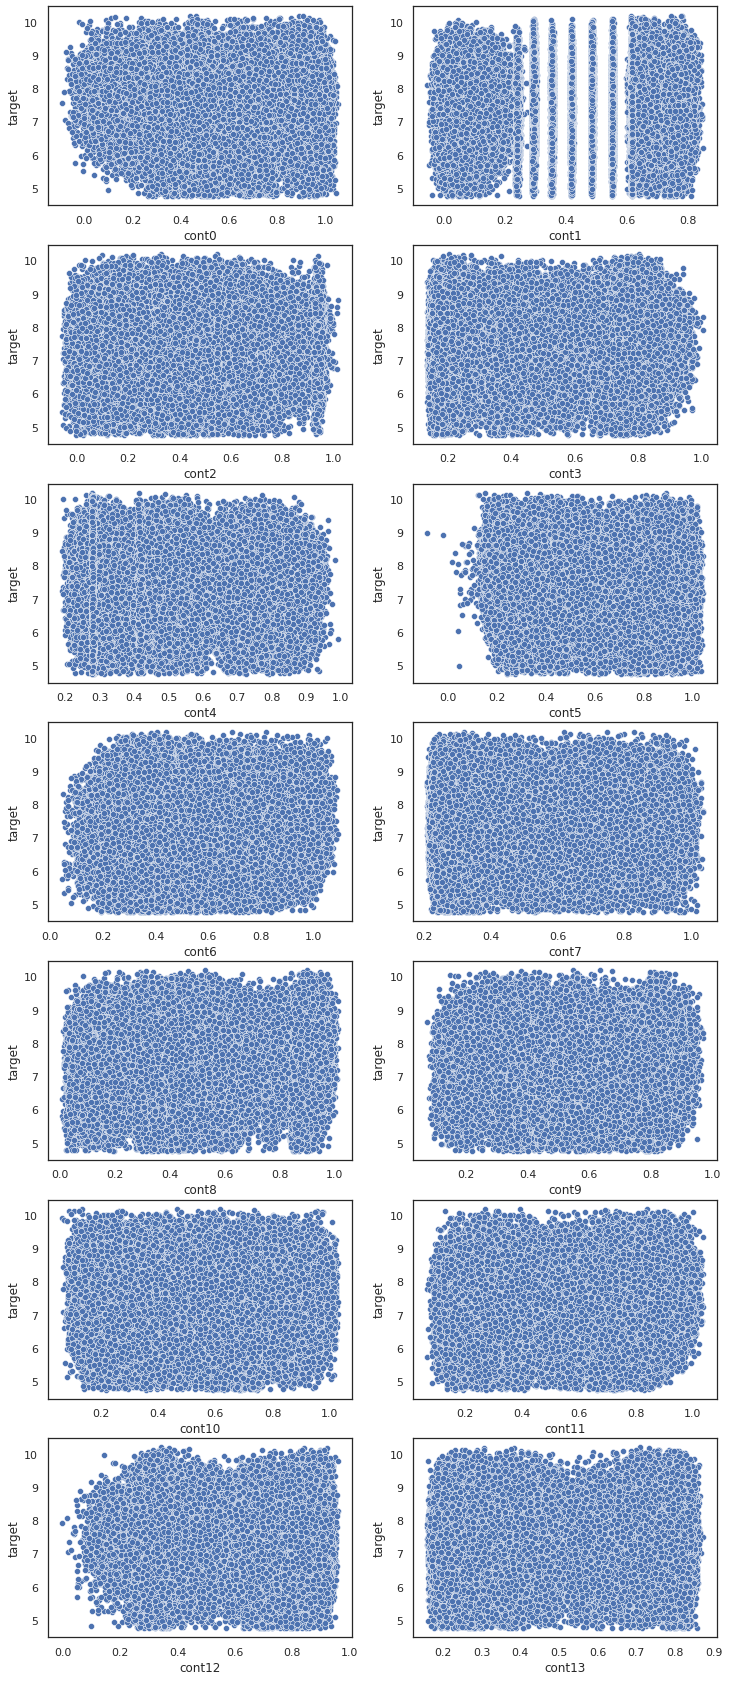

In [50]:
idx = np.arange(14, dtype=int).reshape(7,2)
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(12, 30))
for i in range(7):
    for j in range(2):
        sns.scatterplot(x=train['cont'+str(idx[i][j])], y=train['target'], ax=ax[i][j])
plt.show()

# Feature Engineering and Selections

## 1. Categorical Features: Labeling

In [12]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
data =  pd.concat(objs=[train, test], axis=0)

### 1.1. Label Encoder

In [13]:
categorical_features = ['cat' + str(i) for i in range(10)]
for feature in categorical_features:
    encoder = LabelEncoder()
    encoder.fit(data[feature].values)
    data[feature] = encoder.transform(data[feature].values)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499641 entries, 1 to 499995
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    499641 non-null  int64  
 1   cat1    499641 non-null  int64  
 2   cat2    499641 non-null  int64  
 3   cat3    499641 non-null  int64  
 4   cat4    499641 non-null  int64  
 5   cat5    499641 non-null  int64  
 6   cat6    499641 non-null  int64  
 7   cat7    499641 non-null  int64  
 8   cat8    499641 non-null  int64  
 9   cat9    499641 non-null  int64  
 10  cont0   499641 non-null  float64
 11  cont1   499641 non-null  float64
 12  cont2   499641 non-null  float64
 13  cont3   499641 non-null  float64
 14  cont4   499641 non-null  float64
 15  cont5   499641 non-null  float64
 16  cont6   499641 non-null  float64
 17  cont7   499641 non-null  float64
 18  cont8   499641 non-null  float64
 19  cont9   499641 non-null  float64
 20  cont10  499641 non-null  float64
 21  cont11  49

## 2. Train and Test sets preparation

In [15]:
train_ohe = data[:train_len]
test_ohe  = data[train_len:]

In [16]:
test_ohe.drop('target', axis=1, inplace=True)

In [17]:
target = train_ohe.pop('target')

## 2.1. Standardization

In [18]:
scaler = StandardScaler()
scaler.fit(train_ohe)
train_scaled = scaler.transform(train_ohe)
test_scaled  = scaler.transform(test_ohe)

## 2.2. Train, Validation, Test sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(train_scaled, target, test_size=0.20)

# ML Model 

## 1. Random Forest Regression

In [20]:
rf_reg = RandomForestRegressor(n_estimators=50, n_jobs=-1)
scores = cross_val_score(rf_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  5.2min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.2min finished


In [21]:
rmse_scores = np.sqrt(-1*scores)
print(rmse_scores)

[0.85825404 0.85619933 0.86066516 0.86142097 0.85933926 0.86185047
 0.86105107 0.86083166 0.85354041 0.85876786]


In [22]:
print(rmse_scores.mean(), rmse_scores.std())

0.8591920240469516 0.0024965694052150665


In [23]:
rf_reg.fit(X_train, y_train)
pred = rf_reg.predict(X_test)

In [24]:
print(rmse(y_test, pred))

0.8574177615288892


## 2. Linear Regression

In [229]:
lr_reg = LinearRegression()
scores = cross_val_score(lr_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=2)
rmse_scores = np.sqrt(-1*scores)
print(np.round(rmse_scores,3))
print(np.round(rmse_scores.mean(),3), np.round(rmse_scores.std(),3))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[0.858 0.862 0.861 0.86  0.862 0.853 0.858 0.857 0.86  0.86 ]
0.859 0.003


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    7.8s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.9s finished


In [230]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

In [231]:
print(np.round(rmse(y_test, pred),3))

0.855


In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

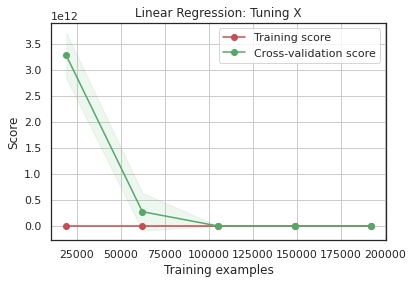

In [235]:
g = plot_learning_curve(LinearRegression(), "Linear Regression: Tuning X", X_train, y_train, cv=5)

In [248]:
lr_reg = LinearRegression()
train_sizes, train_scores, test_scores = learning_curve(lr_reg, X_train, y_train, cv=10, n_jobs=-1, 
                                                        scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(.1, 1.0, 10))

In [249]:
train_scores = np.sqrt(-1*train_scores)
test_scores  = np.sqrt(-1*test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

In [251]:
print(np.round(train_scores_mean,3))

[0.859 0.86  0.859 0.86  0.86  0.859 0.859 0.859 0.859 0.859]


In [252]:
print(np.round(test_scores_mean,3))

[2.83871458e+11 2.47937456e+12 2.70148812e+11 3.53719553e+11
 8.60000000e-01 8.59000000e-01 8.59000000e-01 8.59000000e-01
 8.59000000e-01 8.59000000e-01]


In [316]:
from sklearn.utils import shuffle
X_train_rand, y_train_rand = shuffle(X_train, y_train)

lr_reg = LinearRegression()
rmse_trains = []
rmse_tests  = []
for i in range(1,11):
    X_train_partial = X_train_rand[:20000*i]
    y_train_partial = y_train_rand[:20000*i]
    lr_reg.fit(X_train_partial, y_train_partial)
    pred_train = lr_reg.predict(X_train_partial)
    pred_test  = lr_reg.predict(X_test)
    
    rmse_train = rmse(y_train_partial, pred_train)
    rmse_test  = rmse(y_test, pred_test)
    
    rmse_trains.append(rmse_train)
    rmse_tests.append(rmse_test)
    print("{0:4d}: {1:.4f} | {2:.4f}".format(i, rmse_train, rmse_test))

   1: 0.8581 | 13958272481.5073
   2: 0.8581 | 9949163117711.1094
   3: 0.8575 | 145497250855.7099
   4: 0.8574 | 913600516902.1448
   5: 0.8587 | 700202673440.9062
   6: 0.8577 | 0.8555
   7: 0.8580 | 0.8555
   8: 0.8587 | 0.8555
   9: 0.8582 | 0.8555
  10: 0.8583 | 0.8554


## 2.2. Lasso

In [267]:
from sklearn.utils import shuffle
X_train_rand, y_train_rand = shuffle(X_train, y_train)
X_train_partial = X_train_rand[:20000]
y_train_partial = y_train_rand[:20000]

In [268]:
lasso_reg = Lasso()
params={'alpha':[0.001, 0.03, 0.1, 0.3, 1, 3]}
lasso_grid_reg = grid_search(lasso_reg, params, X_train_partial, y_train_partial, cv=10, n_jobs=6, verbose=1)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'alpha': 0.001} 0.8610245273514894


In [265]:
lasso_reg = Lasso()
params={'alpha':[0.001, 0.03, 0.1, 0.3, 1, 3]}
lasso_grid_reg = grid_search(lasso_reg, params, X_train, y_train, cv=10, n_jobs=6, verbose=1)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'alpha': 0.001} 0.8590965746267626


In [270]:
lasso_best = lasso_grid_reg.best_estimator_
lasso_best.fit(X_train_partial, y_train_partial)
pred = lasso_best.predict(X_test)
print(np.round(rmse(y_test, pred),3))

0.857


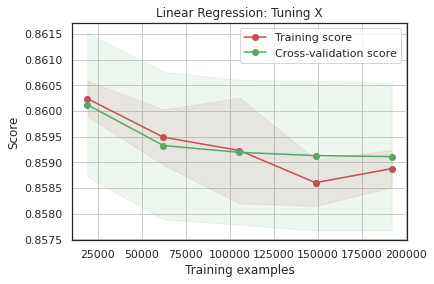

In [317]:
g = plot_learning_curve(Lasso(alpha=0.001), "Linear Regression: Tuning X", X_train, y_train, cv=5)

In [289]:
from sklearn.utils import shuffle
X_train_rand, y_train_rand = shuffle(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
rmse_trains = []
rmse_tests  = []
for i in range(1,11):
    X_train_partial = X_train_rand[:20000*i]
    y_train_partial = y_train_rand[:20000*i]
    lasso_reg.fit(X_train_partial, y_train_partial)
    pred_train = lasso_reg.predict(X_train_partial)
    pred_test  = lasso_reg.predict(X_test)
    
    rmse_train = rmse(y_train_partial, pred_train)
    rmse_test  = rmse(y_test, pred_test)
    
    rmse_trains.append(rmse_train)
    rmse_tests.append(rmse_test)
    print("{0:4d}: {1:.4f} | {2:.4f}".format(i, rmse_train, rmse_test))

   1: 0.8510 | 0.8566
   2: 0.8565 | 0.8559
   3: 0.8584 | 0.8557
   4: 0.8574 | 0.8557
   5: 0.8585 | 0.8557
   6: 0.8592 | 0.8556
   7: 0.8596 | 0.8555
   8: 0.8590 | 0.8555
   9: 0.8589 | 0.8555
  10: 0.8591 | 0.8554


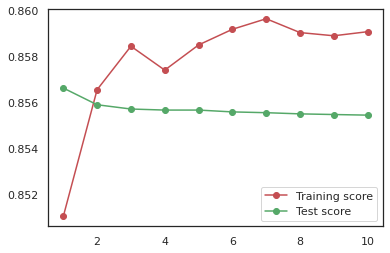

In [290]:
plt.figure()
plt.plot(np.arange(1,11), rmse_trains, 'o-', color="r", label="Training score")
plt.plot(np.arange(1,11), rmse_tests,  'o-', color="g", label="Test score")
plt.legend(loc="best")

### 2.3. Ridge

In [337]:
ridge_reg = Ridge()
params={'alpha':[0.001, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000]}
ridge_grid_reg = grid_search(ridge_reg, params, X_train, y_train, cv=10, n_jobs=6, verbose=1)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 1000} 0.8591053301160012


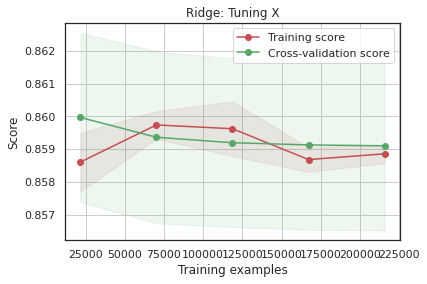

In [349]:
g = plot_learning_curve(Ridge(alpha=1000), "Ridge: Tuning X", X_train, y_train, cv=10)

### 2.4. ElasticNet

In [352]:
params = {'alpha':[0.001, 0.03, 0.01, 1],
          'l1_ratio':[0.1, 0.3, 0.5, 0.7, 0.9]}

elastic_net = ElasticNet()
elastic_grid_reg = grid_search(elastic_net, params, X_train, y_train, cv=10, n_jobs=6, verbose=1)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
{'alpha': 0.001, 'l1_ratio': 0.7} 0.8590899834103704


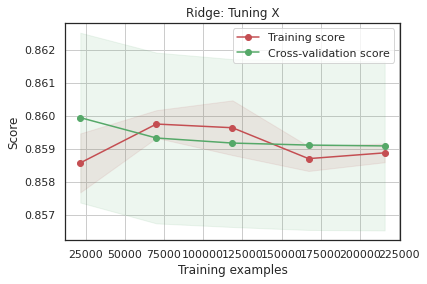

In [353]:
g = plot_learning_curve(ElasticNet(alpha=0.001, l1_ratio=0.7), "Elastic Net: Tuning X", X_train, y_train, cv=10)

### 2.5. Feature Importances

In [319]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)
print(np.round(rmse(y_test, pred),3))

0.855


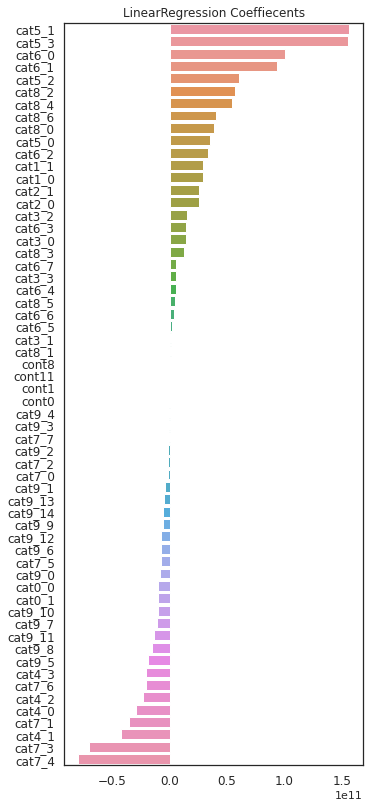

In [348]:
visualize_coefficient(lr_reg, train_ohe, 30, figsize=(5,11))

In [323]:
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
pred = lasso_reg.predict(X_test)
print(np.round(rmse(y_test, pred),3))

0.855


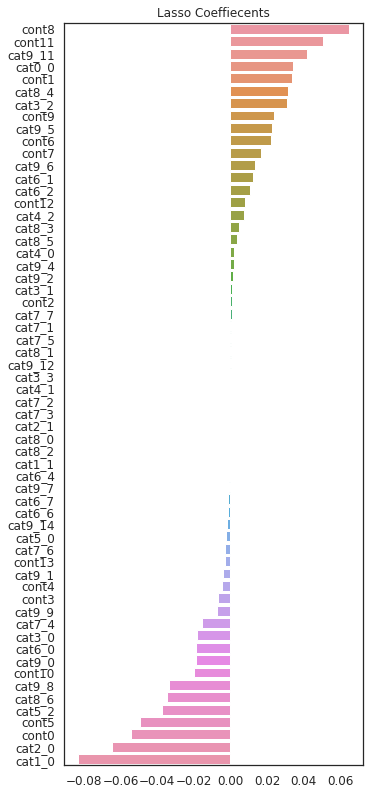

In [346]:
visualize_coefficient(lasso_reg, train_ohe, 30, figsize=(5,11))

In [338]:
ridge_reg = Ridge(alpha=1000)
ridge_reg.fit(X_train, y_train)
pred = ridge_reg.predict(X_test)
print(np.round(rmse(y_test, pred),3))

0.855


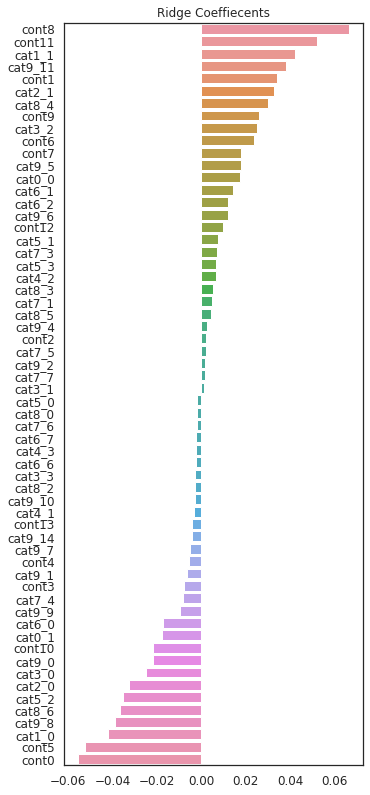

In [347]:
visualize_coefficient(ridge_reg, train_ohe, 30, figsize=(5,11))

In [355]:
elastic_reg = ElasticNet(alpha=0.001, l1_ratio=0.7)
elastic_reg.fit(X_train, y_train)
pred = elastic_reg.predict(X_test)
print(np.round(rmse(y_test, pred),3))

0.855


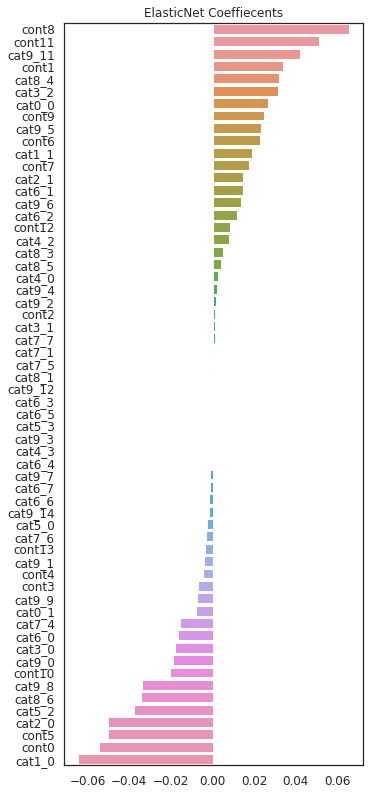

In [356]:
visualize_coefficient(elastic_reg, train_ohe, 30, figsize=(5,11))

## 3. Light GBM

In [25]:
from lightgbm import LGBMRegressor

In [31]:
X_train.shape

(239712, 24)

In [37]:
from sklearn.utils import shuffle
X_train_rand, y_train_rand = shuffle(X_train, y_train, random_state=56)
X_train_p = X_train_rand[:60000]
y_train_p = y_train_rand[:60000]

X_test_list = []
y_test_list = []
for i in range(15):
    X_test_p  = X_train_rand[60000+10000*i:60000+10000*(i+1)]
    y_test_p  = y_train_rand[60000+10000*i:60000+10000*(i+1)]
    
    X_test_list.append(X_test_p)
    y_test_list.append(y_test_p)

## 3.1. Light GBM without tuning

In [38]:
lgbm_reg = LGBMRegressor(n_estimators=300)
%time scores = cross_val_score(lgbm_reg, X_train_p, y_train_p, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
rmse_list = np.sqrt(-scores)
print(np.round(rmse_list,4))
print(np.round(np.mean(rmse_list),4))

CPU times: user 59.7 ms, sys: 12 ms, total: 71.7 ms
Wall time: 2.65 s
[0.828  0.8533 0.8527 0.857  0.8504 0.8486 0.8412 0.8497 0.8485 0.8539]
0.8483


In [39]:
lgbm_reg = LGBMRegressor(n_estimators=300)
lgbm_reg.fit(X_train_p, y_train_p)

LGBMRegressor(n_estimators=300)

In [41]:
for i in range(15):
    pred = lgbm_reg.predict(X_test_list[i])
    print(np.round(rmse(y_test_list[i], pred),4))

0.8466
0.8517
0.8441
0.8517
0.8493
0.8471
0.8515
0.8508
0.8531
0.839
0.8409
0.8393
0.8392
0.8456
0.8462


In [42]:
print(np.round(np.mean(rmse_list),4), np.round(np.std(rmse_list),4))

0.8483 0.0079


## 3.2. Hyper Parameter Tuning

In [43]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[50, 100, 200], 
          'learning_rate':[0.01, 0.03, 0.1],
          'reg_lambda':[0.01, 0.1, 1, 10], 
          'reg_alpha':[0.01, 0.1, 1, 10]}

lgbm_reg = LGBMRegressor()
grid_model = GridSearchCV(estimator=lgbm_reg, param_grid=params, scoring='neg_mean_squared_error',
                                cv=10, return_train_score=True, n_jobs=-1, verbose=2)
%time grid_model.fit(X_train_p, y_train_p)
print(np.sqrt(-1*grid_model.best_score_))
print(grid_model.best_params_)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
CPU times: user 14.3 s, sys: 692 ms, total: 15 s
Wall time: 4min 40s
0.8447182247160567
{'learning_rate': 0.1, 'n_estimators': 100, 'reg_alpha': 10, 'reg_lambda': 0.1}


In [44]:
lgbm_reg = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, reg_alpha=10, reg_lambda=0.1)
lgbm_reg.fit(X_train_p, y_train_p)

LGBMRegressor(max_depth=10, reg_alpha=10, reg_lambda=0.1)

In [46]:
rmse_list = []
for i in range(15):
    pred = lgbm_reg.predict(X_test_list[i])
    score = rmse(y_test_list[i], pred)
    rmse_list.append(score)
    print(np.round(score,4))

0.8432
0.8505
0.8402
0.8481
0.8459
0.8442
0.8501
0.8475
0.8493
0.8352
0.8389
0.8382
0.8379
0.844
0.8412


In [47]:
print(np.round(np.mean(rmse_list),4), np.round(np.std(rmse_list),4))

0.8436 0.0047


## 3.3. Predictions

In [48]:
predictions = lgbm_reg.predict(test_scaled)

# 4. XGBoost

In [41]:
from xgboost import XGBRegressor

In [42]:
from sklearn.utils import shuffle
X_train_rand, y_train_rand = shuffle(X_train, y_train, random_state=56)
X_train_p = X_train_rand[:50000]
y_train_p = y_train_rand[:50000]


X_test_list = []
y_test_list = []
for i in range(1,21):
    X_test_p  = X_train_rand[50000+10000*i:50000+10000*(i+1)]
    y_test_p  = y_train_rand[50000+10000*i:50000+10000*(i+1)]
    
    X_test_list.append(X_test_p)
    y_test_list.append(y_test_p)

In [43]:
xgb_reg = XGBRegressor(n_estimators=300)
%time scores = cross_val_score(xgb_reg, X_train_p, y_train_p, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
rmse_list = np.sqrt(-scores)
print(np.round(rmse_list,4))
print(np.round(np.mean(rmse_list),4))

CPU times: user 103 ms, sys: 138 ms, total: 241 ms
Wall time: 3min 54s
[0.8897 0.8897 0.8916 0.8875 0.8836 0.8837 0.881  0.9074 0.8829 0.8849]
0.8882


In [44]:
xgb_reg = XGBRegressor(n_estimators=300)
xgb_reg.fit(X_train_p, y_train_p)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
for i in range(18):
    pred = xgb_reg.predict(X_test_list[i])
    print(np.round(rmse(y_test_list[i], pred),4))

0.8824
0.8806
0.893
0.8822
0.8828
0.8768
0.8854
0.8758
0.8812
0.8758
0.8866
0.8802
0.8864
0.8804
0.8674
0.8877
0.8884
0.8777


# 5. SVR

In [47]:
from sklearn.utils import shuffle
X_train_rand, y_train_rand = shuffle(X_train, y_train, random_state=56)
X_train_p = X_train_rand[:50000]
y_train_p = y_train_rand[:50000]


X_test_list = []
y_test_list = []
for i in range(1,21):
    X_test_p  = X_train_rand[50000+10000*i:50000+10000*(i+1)]
    y_test_p  = y_train_rand[50000+10000*i:50000+10000*(i+1)]
    
    X_test_list.append(X_test_p)
    y_test_list.append(y_test_p)

In [48]:
help(SVR)

Help on class SVR in module sklearn.svm._classes:

class SVR(sklearn.base.RegressorMixin, sklearn.svm._base.BaseLibSVM)
 |  Epsilon-Support Vector Regression.
 |  
 |  The free parameters in the model are C and epsilon.
 |  
 |  The implementation is based on libsvm. The fit time complexity
 |  is more than quadratic with the number of samples which makes it hard
 |  to scale to datasets with more than a couple of 10000 samples. For large
 |  datasets consider using :class:`~sklearn.svm.LinearSVR` or
 |  :class:`~sklearn.linear_model.SGDRegressor` instead, possibly after a
 |  :class:`~sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  Read more in the :ref:`User Guide <svm_regression>`.
 |  
 |  Parameters
 |  ----------
 |  kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf'
 |       Specifies the kernel type to be used in the algorithm.
 |       It must be one of 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or
 |       a callable.
 |       If n

In [ ]:
svr_reg = SVR()
%time scores = cross_val_score(svr_reg, X_train_p, y_train_p, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
rmse_list = np.sqrt(-scores)
print(np.round(rmse_list,4))
print(np.round(np.mean(rmse_list),4))

In [ ]:
svr_reg = SVR()
svr_reg.fit(X_train_p, y_train_p)

In [ ]:
for i in range(18):
    pred = svr_reg.predict(X_test_list[i])
    print(np.round(rmse(y_test_list[i], pred),4))

--------------

# Submit

In [49]:
submission = pd.read_csv("./input/sample_submission.csv")
submission["target"] = predictions

print(submission.shape)
submission.head()

(200000, 2)


,id,target
0,0,7.754408
1,5,7.807360
2,15,7.749058
3,16,7.410694
4,17,7.202320


In [50]:
submission.to_csv("./score_submission_02192021_ver4_lgbm.csv", index=False)